# CGM prediction tests #
Michael Strand / Chelsea Huynh


## Considerations: ##
    - Choosing predicting features: We need 5 minutes worth of readings to predict 1 glucose measure. If there are m glucose measures then we must be careful that #features * 5 * (measure frequency) < m, otherwise the system is overdetermined.

In [1]:
import random

def ltuple_msgd(A_tilde, y, maxiter, p, ell, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))
    
    # Create Matrix Q for the update function
    L_matrix = np.zeros((n,n))
    for i in range(0, n - (n % ell), ell):
        v = np.zeros((n))
        v[i:i + ell] = 1
        L_matrix = L_matrix + (np.outer(v,v))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        Ai_tilde = A_tilde[i,:]
        
        # split these since numpy is weird with matrix mults and we don't want any mistakes
        At = np.transpose(Ai_tilde)
        A1 = Ai_tilde*xhat - p*y[i]
        AA = np.dot(At, A1).reshape((n,1))
        BB = np.multiply(L_matrix, np.outer(Ai_tilde, Ai_tilde))
        CC = np.dot(BB, xhat)
        
        gxk = (1/p**2)*AA - ((1-p)/p**2)*CC
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        current_iter += 1
            
    return resid_err

In [2]:
import random

# sgd to test on unmasked analogs

def sgd(A_tilde, y, maxiter,alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        Ai_tilde = A_tilde[i,:]
        
        # split these since numpy is weird with matrix mults and we don't want any mistakes
        At = np.transpose(Ai_tilde)
        A1 = Ai_tilde*xhat - p*y[i]
        AA = np.dot(At, A1).reshape((n,1))
        
        gxk = (1/p**2)*AA
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        current_iter += 1
            
    return resid_err

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt

# Cleans and preps patient 1 day 2 data (trimming & organizing)

# breathing table

raw_breathing = pd.read_csv('2014_10_02-10_56_44_Breathing.csv')
raw_breathing['Time'] = raw_breathing['Time'].str[10:]
raw_breathing_slim = raw_breathing.loc[(raw_breathing['Time']).str[-3:] == '420']
raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]

# ecg table

raw_ecg = pd.read_csv('2014_10_02-10_56_44_ECG.csv')
raw_ecg['Time'] = raw_ecg['Time'].str[10:]
raw_ecg_slim = raw_ecg.loc[(raw_ecg['Time']).str[-3:] == '424']
raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]

# trim glucose measures so we can properly shape our A matrix 

raw_glucose = pd.read_csv('glucose.csv')
raw_glucose_day1 = raw_glucose.loc[(raw_glucose['date']).str[-1] == '2']
raw_glucose_day1 = raw_glucose_day1.drop('comments', axis=1)

# start at 10:56
raw_glucose_day1_trim = raw_glucose_day1.iloc[135:-30]
raw_glucose_day1_trim['time'] = raw_glucose_day1_trim['time'].str[:5]

# drop manual imputations for conistancy 
raw_glucose_day1_trim = raw_glucose_day1_trim.loc[(raw_glucose_day1_trim['type']) == 'cgm']

# Concate floating tables with summary table 
raw_summary = pd.read_csv('2014_10_02-10_56_44_Summary.csv')
raw_summary = raw_summary.iloc[436:-424] # trim measurements that don't correspond to a prediction (5 minute interval)
raw_summary['Time'] = raw_summary['Time'].str[10:]
raw_summary['Time'] = raw_summary['Time'].str[:9]

noise = raw_summary[['ECGNoise']]

# junk variables (all constant)
raw_summary = raw_summary.drop('BRNoise', axis=1)
raw_summary = raw_summary.drop('BRConfidence', axis=1)
raw_summary = raw_summary.drop('GSR', axis=1)
raw_summary = raw_summary.drop('LinkQuality', axis=1)
raw_summary = raw_summary.drop('RSSI', axis=1)
raw_summary = raw_summary.drop('TxPower', axis=1)
raw_summary = raw_summary.drop('ECGNoise', axis=1)

# HR != 0 in a living human
raw_summary['HR'] = raw_summary['HR'].mask(raw_summary['HR'] == 0).ffill()

C:\Users\mikew\AppData\Local\Temp/ipykernel_14032/819062081.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_14032/819062081.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_14032/819062081.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [62]:
raw_summary

,Time,HR,BR,SkinTemp,Posture,Activity,PeakAccel,BatteryVolts,BatteryLevel,BRAmplitude,...,LateralMin,LateralPeak,SagittalMin,SagittalPeak,DeviceTemp,StatusInfo,CoreTemp,AuxADC1,AuxADC2,AuxADC3
436,11:04:00,116.0,12.2,-3276.8,-9,0.06,0.12,4.152,92,23.0,...,-0.20,-0.10,0.03,0.16,27.7,531,36.9,416,422,483
437,11:04:01,116.0,12.2,-3276.8,-9,0.08,0.13,4.152,92,24.0,...,-0.22,-0.09,-0.02,0.16,27.7,531,36.9,415,421,483
438,11:04:02,116.0,12.5,-3276.8,-9,0.07,0.13,4.152,92,25.0,...,-0.25,-0.07,-0.01,0.18,27.7,531,36.9,415,422,483
439,11:04:03,117.0,12.5,-3276.8,-8,0.04,0.12,4.152,92,23.0,...,-0.19,-0.03,-0.01,0.18,27.7,528,36.9,415,422,483
440,11:04:04,117.0,12.7,-3276.8,-9,0.04,0.08,4.152,92,21.0,...,-0.21,-0.10,-0.02,0.12,27.7,531,36.9,415,423,484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38231,21:33:55,124.0,7.5,-3276.8,-18,0.01,0.03,3.807,34,15.0,...,0.16,0.24,0.20,0.26,33.2,531,35.5,420,429,490
38232,21:33:56,124.0,8.2,-3276.8,-18,0.01,0.12,3.807,34,15.0,...,0.19,0.26,0.21,0.26,33.2,531,35.5,415,419,484
38233,21:33:57,124.0,8.2,-3276.8,-18,0.01,0.03,3.807,34,14.0,...,0.18,0.26,0.22,0.25,33.2,531,35.5,414,419,483
38234,21:33:58,124.0,9.2,-3276.8,-18,0.01,0.03,3.807,34,14.0,...,0.16,0.25,0.22,0.26,33.2,531,35.5,414,421,483


In [55]:
from sklearn.preprocessing import StandardScaler

# standardize

qualities = pd.concat([raw_summary.set_index('Time'), 
                       raw_breathing_slim.set_index('Time'), 
                       raw_ecg_slim.set_index('Time')],
                axis=1, join='inner') # note the inner join forces ecg/breathing tables to have the same trimmed times

qualities_copy = qualities.copy()
qualities_norm = qualities_copy.copy()
y_glucose = pd.DataFrame(raw_glucose_day1_trim['glucose']).to_numpy().reshape(-1,1)

qualities_norm = qualities_norm[['HR', 'EcgWaveform', 'ECGAmplitude']]
qualities_copy = qualities_copy[['HR', 'EcgWaveform', 'ECGAmplitude']]

scaler = StandardScaler(copy = True)
qualities_norm = scaler.fit_transform(qualities_norm)
y_glucose_norm = scaler.fit_transform(y_glucose)

In [64]:
display(pd.DataFrame(qualities_norm))

,0,1,2
0,1.786433,-1.537906,0.461775
1,1.786433,-1.576596,0.461775
2,1.786433,0.302044,0.461775
3,1.828797,3.195237,0.461775
4,1.828797,-0.905960,0.461775
...,...,...,...
37795,2.125345,-0.639425,-0.174605
37796,2.125345,-0.566343,-0.174605
37797,2.125345,-0.501859,-0.174605
37798,2.125345,-0.433076,-0.174605


In [56]:
# reshape

eta = 5 # how many times per minute do we take a reading

# copies (to prevent overlapping changes if reruns are necessary)
qualities_copy2 = qualities_copy.copy()
qualities_copy2 = pd.DataFrame(qualities_copy2)
qualities_norm_copy = qualities_norm.copy()
qualities_norm_copy = pd.DataFrame(qualities_norm_copy)

glucose_measure_counts = len(raw_glucose_day1_trim)
feature_count = len(qualities_copy.columns)

m = glucose_measure_counts

qualities_norm_copy = qualities_norm_copy.iloc[::60//eta, :] # choose every 60/eta'th row 
qualities_copy2 = qualities_copy2.iloc[::60//eta, :]

A_norm = np.reshape(qualities_norm_copy.to_numpy(), (-1)) # flatten
A_norm = np.reshape(A_norm, (m,-1)) # reshape - each row corresponds to 5*60 seconds (in eta intervals) of readings
A = np.reshape(qualities_copy2.to_numpy(), (-1))
A = np.reshape(A, (m,-1)) 

In [65]:
display(pd.DataFrame(A_norm))

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,1.786433,-1.537906,0.461775,2.125345,0.641661,-0.635981,3.057352,1.991531,-0.635981,3.396264,...,0.604961,-0.077582,-0.020377,0.620870,-0.204674,0.160179,0.636780,-0.119946,0.035510,0.620870
1,-0.162310,-0.059067,0.652689,-0.247038,0.142983,0.668599,-0.162310,-0.024676,0.716327,-0.035218,...,-0.667800,-0.247038,-0.149345,0.732237,1.193337,-0.084861,0.716327,1.447521,0.095695,0.668599
2,1.405157,-0.011779,0.493594,1.405157,-0.037573,0.557232,1.362793,0.065602,0.684508,1.235701,...,-0.413248,1.955889,0.112891,-0.413248,2.125345,-0.381488,-0.445067,3.099716,0.078499,-0.445067
3,3.438628,0.422415,-0.445067,3.353900,0.035510,-0.445067,3.311536,1.454163,-0.445067,3.226808,...,-0.381429,2.591348,-0.948950,-0.381429,2.887896,-0.243922,-0.381429,2.845532,-1.507813,-0.445067
4,2.760804,0.512693,-0.445067,2.803168,-0.071964,-0.445067,2.972624,0.482600,-0.445067,3.184444,...,-0.174605,0.430786,-0.519055,-0.174605,0.430786,-0.441674,-0.174605,0.430786,-0.424478,-0.174605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.374130,0.009716,-0.174605,-0.374130,-0.028975,-0.174605,-0.374130,0.022613,-0.174605,-0.374130,...,-0.174605,-0.374130,0.035510,-0.174605,-0.374130,0.074200,-0.174605,-0.374130,0.026912,-0.174605
122,-0.374130,-0.028975,-0.174605,-0.374130,-0.003181,-0.174605,-0.374130,-0.059067,-0.174605,-0.374130,...,-0.174605,-0.374130,-0.286912,-0.174605,0.218966,1.871161,0.048128,-0.374130,-2.083872,-0.174605
123,-0.374130,-0.149345,-0.174605,-0.374130,-0.037573,-0.174605,-0.374130,0.082798,-0.174605,-0.374130,...,-0.174605,0.896789,0.044107,-0.174605,2.040617,1.570234,2.975477,2.040617,-0.372891,-0.445067
124,2.040617,-0.028975,-0.174605,2.040617,-0.024676,-0.174605,2.040617,0.009716,-0.174605,2.040617,...,-0.190515,0.218966,0.001118,-0.222334,0.261330,-0.605034,-0.174605,0.176602,0.516992,2.434554


In [66]:
noise.describe()

,ECGNoise
count,37800.000000
mean,0.000348
std,0.000494
min,0.000020
25%,0.000080
50%,0.000160
75%,0.000400
max,0.009080


In [77]:
# masking by noise

noise_copy = noise.copy()
df_A = pd.DataFrame(A)
df_A_norm = pd.DataFrame(A_norm)

n = A.shape[1]
mask = np.ones((m,n))

noise_vec = noise_copy.to_numpy()
df_A_mask = df_A.copy().to_numpy()
df_A_norm_mask = df_A_norm.copy().to_numpy()

too_high_noise = 0.0008

index = 0
zeros = 0

# generate mask
for i in range(m):
    for j in range(n//feature_count):
        
        if noise_vec[index] > too_high_noise:
            
            zeros += feature_count
            df_A_mask[i, feature_count*j:feature_count*(j+1)] = 0
            df_A_norm_mask[i, feature_count*j:feature_count*(j+1)] = 0

        index += 1

<AxesSubplot:>

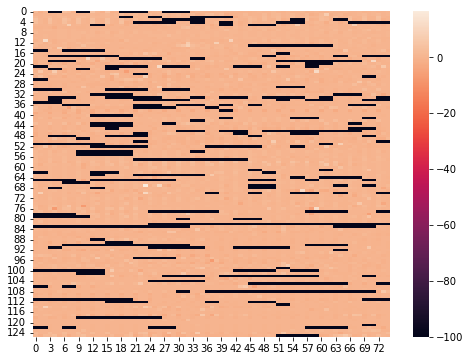

In [76]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# here I display df_A_norm_mask with -100 imputed, but we actually test with 0 imputation

fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(df_A_norm_mask, annot=False)

p: 0.8673015873015872
dimension: (126, 75)
features: 3


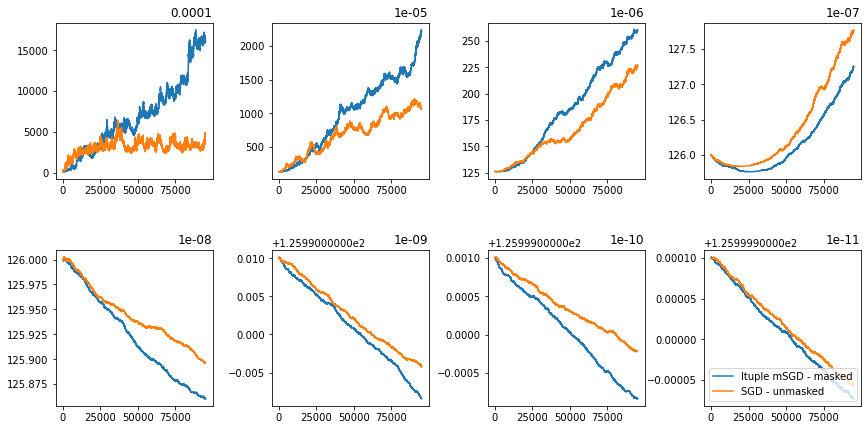

In [67]:
A_tilde = df_A_norm_mask
A = df_A_norm.to_numpy()

maxiter = 95000
p = 1 - zeros/(m*n) # estimate for probability data present
ell = feature_count

print('p:', p)
print('dimension:', A_norm.shape)
print('features:', feature_count)

fig, axes = plt.subplots(2, 3, figsize=(13, 7))
fig.tight_layout(pad = 5)

for i in range(8):
    alpha = 10**(-(i+4))
    
    lerr = ltuple_msgd(A_tilde, y_glucose_norm, maxiter, p, ell, alpha)
    err = sgd(A, y_glucose_norm, maxiter, alpha)
    plt.subplot(2, 4, i+1)
    plt.plot(lerr, label = 'ltuple mSGD')
    plt.plot(err, label = 'SGD') 
    plt.title(alpha, loc='right')

plt.legend(['ltuple mSGD - masked', 'SGD - unmasked'], loc = 'lower left')    

plt.show()

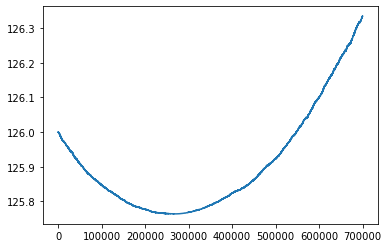

In [72]:
maxiter = 700000
alpha = 10**(-8)
lerr = ltuple_msgd(A_tilde, y_glucose_norm, maxiter, p, ell, alpha)

plt.plot(lerr)